In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import scipy as sp
import numpy as np
import pickle as pickle
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
from IPython.display import display
%matplotlib inline
#%config InlineBackend.close_figures = False
from scipy.io.idl import readsav
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
#from pysynphot import observation
#from pysynphot import spectrum
import forwardmodel
import ciamod
import band
import TPmod
import cloud

In [2]:
# set up coarse pressure grid and fine pressure grid
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
coarsePress = pow(10,logcoarsePress)
logfinePress = np.arange(-4.0, 2.5, 0.1)
finePress = pow(10,logfinePress)
print finePress.size
print coarsePress.size
print finePress

65
13
[  1.00000000e-04   1.25892541e-04   1.58489319e-04   1.99526231e-04
   2.51188643e-04   3.16227766e-04   3.98107171e-04   5.01187234e-04
   6.30957344e-04   7.94328235e-04   1.00000000e-03   1.25892541e-03
   1.58489319e-03   1.99526231e-03   2.51188643e-03   3.16227766e-03
   3.98107171e-03   5.01187234e-03   6.30957344e-03   7.94328235e-03
   1.00000000e-02   1.25892541e-02   1.58489319e-02   1.99526231e-02
   2.51188643e-02   3.16227766e-02   3.98107171e-02   5.01187234e-02
   6.30957344e-02   7.94328235e-02   1.00000000e-01   1.25892541e-01
   1.58489319e-01   1.99526231e-01   2.51188643e-01   3.16227766e-01
   3.98107171e-01   5.01187234e-01   6.30957344e-01   7.94328235e-01
   1.00000000e+00   1.25892541e+00   1.58489319e+00   1.99526231e+00
   2.51188643e+00   3.16227766e+00   3.98107171e+00   5.01187234e+00
   6.30957344e+00   7.94328235e+00   1.00000000e+01   1.25892541e+01
   1.58489319e+01   1.99526231e+01   2.51188643e+01   3.16227766e+01
   3.98107171e+01   5.011872

In [5]:
modP,modT = np.loadtxt("../Saumon_models/t1400g1000f2.dat",skiprows=1,usecols=(1,2),unpack=True)
tfit = InterpolatedUnivariateSpline(np.log10(modP),modT,k=1)
temp = np.asfortranarray(tfit(np.log10(finePress)),dtype='d')
print temp

[  650.37         657.42577527   664.48155055   671.53732582   678.59310109
   685.64887637   692.70465164   701.43199516   710.47469009   720.51961318
   731.54747462   741.43680234   751.32437027   761.19549645   771.06662263
   781.36426851   791.70021546   801.977911     812.2369258    822.61226121
   833.06963815   843.47905096   854.30240501   866.4121527    879.849088
   894.83971436   910.73310585   926.67662564   944.24714533   963.36191797
   985.87995628  1009.83462671  1036.11746229  1063.65366968  1096.07291181
  1132.14126691  1171.95727454  1218.32912583  1273.98235289  1341.81634012
  1431.24        1524.20118567  1621.93307413  1724.28190615  1831.42494962
  1943.72639878  2078.28297307  2196.10826311  2262.65871381  2328.6745023
  2400.39        2524.76438304  2648.14561605  2770.8506053   2893.46110566
  3016.07160603  3138.6821064   3261.29260677  3383.90310714  3506.51360751
  3629.12410788  3751.73460824  3874.34510861  3996.95560898  4119.56610935]


[(0.2736809413618656, 0.30293120551537384, 0.34120151462119891), (0.48445224059474712, 0.71156067717230687, 0.91769069497791866), (1.1961662281671723, 1.782589514584159, 3.0539810335834474), (35.951655767668505, 92.987676756895482, 161.68954644660636), (1866.2276590395848, 1887.7409333445908, 1925.8177054208306)]

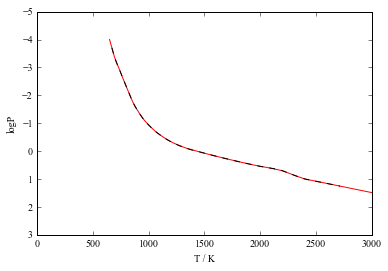

In [6]:
#Tparams = np.array([(0.24961265545013805, 0.29669980226249115, 0.34692402859455584), (0.12282222259062406, 0.15644945610649619, 0.19064094208914834), (-0.229568251913775, 0.16503714060561048, 0.68457833601497942), (3.0008442555754247, 4.1381930691794269, 4.7579819209736272), (4157.089778959039, 4851.2685890221546, 5767.5971072676621)])
#temp = TPmod.set_prof(2,coarsePress,finePress,Tparams[:,1])
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.,3000.,3.0,-5.0])
#plt.plot(miketemp,np.log10(mikepress),'r-')
#plt.plot(temp,np.log10(finePress),'b--')

plt.plot(temp,np.log10(finePress),'r-')
plt.plot(modT,np.log10(modP),'k--')
plt.ylabel(r'logP')
plt.xlabel('T / K')

#

In [17]:
w1 = 0.8
w2 = 2.4

dist = 11.35
# hardwired FWHM of data in microns
fwhm = 0.005


npatches = 1
nclouds = 1


do_clouds = np.array([0],dtype='i')


# CURRENTLY ONLY COPE WITH ONE CLOUDY PATCH.
#SO MAKE ALL CLOUD PARAMETERS THE SAME FOR EASE OF PROCESSING 

cloudnum = np.zeros([npatches,nclouds],dtype='i')
cloudnum[:,:] = 89
cloudtype = np.asfortranarray(np.ones([npatches,nclouds]),dtype='i')
cloudtype[:,0] = 1
#cloudtype[:,1] = 4


use_disort = 0 

# use the fudge factor?
do_fudge = 1

# Set the profile type
proftype = 9

prof = np.full(13,100.)

if (proftype == 9):
    modP,modT = np.loadtxt("../Saumon_models/t1700g1000f2.dat",skiprows=1,usecols=(1,2),unpack=True)
    tfit = InterpolatedUnivariateSpline(np.log10(modP),modT,k=1)
    prof = tfit(logcoarsePress)
    
# place holder values for cloudparams
cloudparams = np.ones([5,npatches,nclouds],dtype='d')
cloudparams[0,:,0] = 4.0
cloudparams[1,:,0] = -0.5
cloudparams[2,:,0] = 0.1
cloudparams[3,:,0] = 0.5
cloudparams[4,:,0] = 0.00

#cloudparams[0,:,1] = 0.0
#cloudparams[1,:,1] = 0.5
#cloudparams[2,:,1] = 3.0
#cloudparams[3,:,1] = 0.5
#cloudparams[4,:,1] = 0.6

pcover = 1.0
bits= np.array([(5.0225060735284526, 5.2071905701033137, 5.2882414217989506), (3.8810409944043399e-20, 4.0255440848136866e-20, 4.1710216532602051e-20), (0.0037438044311316355, 0.0045095531743837639, 0.0052347985565985942), (-31.218892232244485, -31.163579686043196, -31.094588555625002)])
logg = 5.0
r2d2 = np.array(bits[1,1])
dlam = np.array(bits[2,1])

In [18]:
# Get the linelists
ngas = 8
gasnum = np.asfortranarray(np.array([1,4,7,8,10,11,20,21],dtype='i'))
lists = ["../Linelists/H2O_xsecs.pic","../Linelists/co_xsecs.pic","../Linelists/tio_xsecs.pic","../Linelists/vo_xsecs.pic","../Linelists/crh_xsecs.pic" ,"../Linelists/feh_xsecs.pic","../Linelists/K_Mike_xsecs.pic","../Linelists/Na_Mike_xsecs.pic"]

In [9]:
# get the basic framework from water list
rawwavenum, inpress, inlinetemps, inlinelist = pickle.load( open('../Linelists/H2O_xsecs.pic', "rb" ) )
wn1 = 10000./w2
wn2 = 10000. / w1
inwavenum = np.asfortranarray(rawwavenum[np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1)))],dtype='float64')
ntemps = inlinetemps.size
npress= finePress.size
nwave = inwavenum.size
r1 = np.amin(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))
r2 = np.amax(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))

# Here we are interpolating the linelist onto our fine pressure scale.
# pickles have linelist as 4th entry....
linelist = (np.ones([ngas,npress,ntemps,nwave],order='F')).astype('float64', order='F')
for gas in range (0,ngas):
    inlinelist= pickle.load( open(lists[gas], "rb" ) )[3]
    # make missing bits crazy. They are all high pressure, low-temp points.
    #inlinelist[np.isnan(inlinelist)] = 1.0
    for i in range (0,ntemps):
        for j in range (r1,r2+1):
            pfit = InterpolatedUnivariateSpline(np.log10(inpress),np.log10(inlinelist[:,i,j]),k=1)
            linelist[gas,:,i,(j-r1)] = np.asfortranarray(pfit(np.log10(finePress)))

linelist[np.isnan(linelist)] = -50.0


In [19]:
alkratio = 16.2
VMR1 = np.full((npress,),-3.5) # water
vmr2 = np.full((npress,),-3.0) # CO
vmr3 = np.full((npress,),-7.5) # TiO
vmr4 = np.full((npress,),-8.5) # VO 
vmr5 = np.full((npress,),-8.0) #CrH 
vmr6 = np.full((npress,),-8.0) # FeH
vmr7 = np.full((npress,),(np.log10((10.**-5.0) / (alkratio+1.))))# K
vmr8 = np.full((npress,),(np.log10((10.**-5.0) * (alkratio / (alkratio+1.)))))
#print VMR1.shape
logVMR = np.asfortranarray(np.reshape((VMR1,vmr2,vmr3,vmr4,vmr5,vmr6,vmr7,vmr8),(ngas,npress)),dtype='float64')
print logVMR.shape
press = np.asfortranarray(finePress,dtype='float32')
temp = np.asfortranarray(temp,dtype='float64')

(8, 65)


In [20]:
cloudprof,cloudrad,cloudsig = cloud.atlas(do_clouds,cloudnum,cloudtype,cloudparams,press)

cloudnum = np.asfortranarray(cloudnum,dtype='i')
cloudrad = np.asfortranarray(cloudrad,dtype='float64')
cloudsig = np.asfortranarray(cloudsig,dtype='float64')
cloudprof = np.asfortranarray(cloudprof,dtype='float64')
pcover = np.asfortranarray(pcover,dtype='float32')
do_clouds = np.asfortranarray(do_clouds,dtype='i')
print do_clouds
print cloudprof[0,:,0]

[0]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [21]:
tmpcia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat",inwavenum)
cia = np.asfortranarray(np.empty((4,ciatemps.size,nwave)),dtype='float32')
cia[:,:,:] = tmpcia[:,:,:nwave] 
ciatemps = np.asfortranarray(ciatemps, dtype='float32')
print cia.shape
print ciatemps.shape
print cia.dtype
print forwardmodel.marv.__doc__

(4, 198, 8334)
(198,)
float32
outspec,phot_press,tau_spec = marv(temp,logg,r2d2,ingasnum,logvmr,pcover,do_clouds,incloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,inpress,inwavenum,inlinelist,cia,ciatemps,use_disort,make_pspec,make_tspec,do_bff,bff)

Wrapper for ``marv``.

Parameters
----------
temp : in/output rank-1 array('d') with bounds (f2py_temp_d0)
logg : input float
r2d2 : input float
ingasnum : in/output rank-1 array('i') with bounds (f2py_ingasnum_d0)
logvmr : in/output rank-2 array('d') with bounds (f2py_logvmr_d0,f2py_logvmr_d1)
pcover : in/output rank-1 array('f') with bounds (f2py_pcover_d0)
do_clouds : in/output rank-1 array('i') with bounds (f2py_do_clouds_d0)
incloudnum : in/output rank-2 array('i') with bounds (f2py_incloudnum_d0,f2py_incloudnum_d1)
cloudrad : in/output rank-3 array('d') with bounds (f2py_cloudrad_d0,f2py_cloudrad_d1,f2py_cloudrad_d2)
cloudsig : in/output rank-3 array('d') with bounds (f2py_cloudsig_d0,f2py_cloudsig_d1,f2py_cloudsig_d2)
cloudprof : i

In [22]:
intab = np.loadtxt("2015_06_1060grid_feh_00_co_10.txt",skiprows=1)
test = np.array(intab)
test2 = test.reshape(60,18,36)
Pgrid = test2[20:21,:,1].reshape(18)
Tgrid =  test2[:,10:11,0].reshape(60)
abunds= test2[:,:,2:]
nlayers = finePress.shape[0]
nabpress = 18
nabtemp = 60
nabgas = 34
ab_myP = np.empty([nabtemp,nlayers,nabgas])
for gas in range (0,nabgas):
    for i in range (0,nabtemp):
            pfit = InterpolatedUnivariateSpline(Pgrid,np.log10(abunds[i,:,gas]),k=1)
            ab_myP[i,:,gas] = pfit(np.log10(finePress))
            
bff_raw = np.empty([nabtemp,nlayers,3])
bff_raw[:,:,0] = ab_myP[:,:,0]
bff_raw[:,:,1] = ab_myP[:,:,2]
bff_raw[:,:,2] = ab_myP[:,:,4]


bff = np.zeros([3,nlayers],dtype="float64") 
bfTgrid = Tgrid


for gas in range(0,3):
    for i in range(0,nlayers):
        tfit = InterpolatedUnivariateSpline(Tgrid,bff_raw[:,i,gas],k=1) 
        bff[gas,i] = 10.**(tfit(temp[i]))

bff = np.asfortranarray(bff, dtype='float64')

In [23]:
print Tgrid
print inlinetemps
print bff

[   75.   100.   110.   120.   130.   140.   150.   160.   170.   180.
   190.   200.   210.   220.   230.   240.   250.   260.   270.   275.
   280.   290.   300.   310.   320.   330.   340.   350.   375.   400.
   425.   450.   475.   500.   575.   650.   725.   800.   900.  1000.
  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.  2000.
  2150.  2300.  2450.  2600.  2800.  3000.  3250.  3500.  3750.  4000.]
[   75.    85.   100.   120.   140.   160.   180.   200.   230.   260.
   300.   350.   400.   500.   650.   800.  1000.  1200.  1400.  1600.
  1800.  2000.  2300.  2600.  3000.  3500.  4000.]
[[  1.74940232e-20   2.56138840e-20   3.81107629e-20   5.76243864e-20
    8.85424330e-20   1.36828359e-19   2.08581018e-19   3.89114653e-19
    7.73916265e-19   1.77242763e-18   3.58304931e-18   5.57668167e-18
    8.85783047e-18   1.43428755e-17   2.37035052e-17   4.10587548e-17
    7.14511771e-17   1.18513945e-16   1.53357393e-16   2.03497164e-16
    2.76540067e-16   3.7600223

In [34]:
tspec = 0
pspec = 0
do_bff = 1  
# now we can call the forward model
tmpoutspec,photspec,tauspec = forwardmodel.marv(temp,logg,r2d2,gasnum,logVMR,pcover,do_clouds,cloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,press,inwavenum,linelist,cia,ciatemps,use_disort,pspec,tspec,do_bff,bff)

outspec = np.zeros((2,nwave),dtype='d')
outspec[:,:] = tmpoutspec[:,:nwave]

In [35]:
#np.savetxt('Ray_TESTspectrum.dat', np.c_[outspec[0],outspec[1]])
print tmpoutspec

[[  2.39980802e+00   2.39923225e+00   2.39865675e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  6.82823701e-15   6.06169710e-15   6.01322767e-15 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


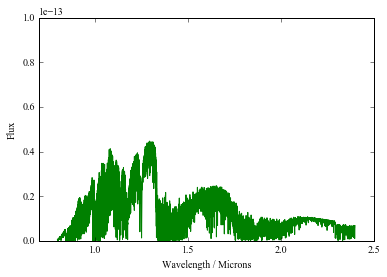

In [36]:
#B = np.empty(nwave,dtype='d') 
#B = 3.14159274*((2.*6.62606957e-34*(2.99792458e8**2.)) / ((outspec[0,:]*1.e-6)**5.)) / ((np.exp((6.62606957e-34*2.99792458e8)/(outspec[0,:]*1e-6*1.3806488e-23*1000.)))-1.) * 1.e-6
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.7, 2.5,0.0,10e-14])
#oldspec = np.loadtxt("8gas_TESTspectrum.dat", unpack=True)
#plt.plot(outspec[0,:],(outspec[1,:] / B),'r-')
#plt.plot(outspec[0,:],B,'b-')
#plt.plot(oldspec[0,:],oldspec[1,:],'r-')
plt.plot(outspec[0,:],outspec[1,:],'g-')
#plt.plot(outspec_c[0,:],outspec_c[1,:],'r-')

#plt.plot(outspec[0,:],(1.+ ((outspec[1,:]- oldspec[1,:])/outspec[1,:]))*1e5,'g-')

#plt.plot(mikespec[0,:],outspec[1,:] / (mikespec[1,:]/1e6),'r-')
#plt.plot(mikespec[0,:],((mikespec[1,:] / 1e6) / outspec[1,:]), 'r-')
#plt.plot(outspec[0,:],np.full(nwave,1.0),'b--')

#plt.plot(outspec[0,:],6.666*outspec[1,:],'b-')
plt.ylabel(r'Flux')
plt.xlabel('Wavelength / Microns')

#asp = 10 / 3.5

#plt.axes().set_aspect(asp)
#plt.savefig('testspec.pdf',format='pdf', dpi=720)

In [37]:
wlen = outspec.shape[1]
wint = outspec[0,0] - outspec[0,wlen-1]
disp = wint / wlen
fwhm = 0.005
gwidth = int(round(fwhm / disp))
print outspec.shape

(2, 8334)


In [38]:
gauss = Gaussian1DKernel(gwidth)
cspec = convolve(outspec[1,:],gauss,boundary='extend')
spec = np.array([outspec[0,::-1],cspec[::-1]])


In [39]:
obspec = np.loadtxt("2M1626_2MassJcalib_trim.dat",unpack=True)
pltspec = np.ones([obspec.shape[1]])
wavenew = obspec[0,:]
wfit = sp.interpolate.splrep(spec[0,:],spec[1,:],s=0)
pltspec = sp.interpolate.splev(wavenew,wfit,der=0)
#np.savetxt('2m2224_Ray_off_test.dat', np.c_[spec[0],spec[1]])

In [40]:
speclen = pltspec.size
unc = np.max(pltspec)
err = np.full(speclen,unc/50)
outflux = np.ones(speclen)
outflux = pltspec + err*np.random.randn(speclen)
    

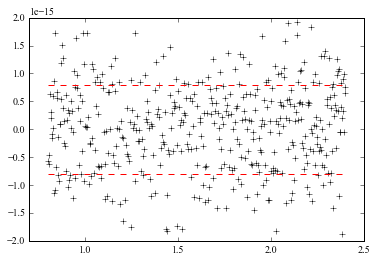

In [41]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.7, 2.5, -2.e-15,2e-15])
plt.plot(wavenew,outflux - pltspec,'k+')
plt.plot(wavenew,err,'r--')
plt.plot(wavenew,-1*err,'r--')

In [42]:
print np.mean(outflux - pltspec)

5.72687503372e-17


In [43]:
np.savetxt('bfftest_ON_1400.dat', np.c_[wavenew,pltspec,err])

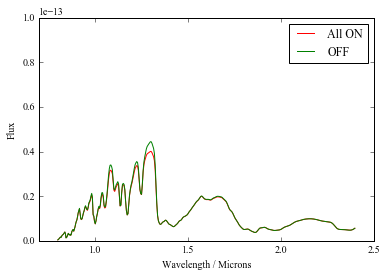

In [47]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.7, 2.5, 0.,10e-14])
bspec = np.loadtxt("bfftest_ON_1400.dat", unpack="true")
t1, = plt.plot(bspec[0],bspec[1],'r-',label="All ON")
bspec = np.loadtxt("bfftest_OFF_1400.dat", unpack="true")
t2, = plt.plot(bspec[0],bspec[1],'g-',label="OFF")
bspec = np.loadtxt("bfftest_OFF_withCloud_4.dat", unpack="true")
#t3, = plt.plot(bspec[0],bspec[1],'b-',linewidth=2.5,label="OFF with cloud")
bspec = np.loadtxt("bfftest_ON_withCloud_4.dat", unpack="true")
#t4, = plt.plot(bspec[0],bspec[1],'y-',label="ON w/ cloud")

#bspec = np.loadtxt("bfftest.dat", unpack="true")
#t5, = plt.plot(bspec[0],bspec[1],'k-',label="OFF")
#plt.plot(spec[0,:],mspec[1,:] / spec[1,:],'g-')
plt.legend(handles=[t1,t2])
plt.ylabel( 'Flux')
plt.xlabel('Wavelength / Microns')


In [23]:
print np.log10(finePress[51])
print cloudprof[0,51,0]

1.1
0.0


In [24]:
print sum(cloudprof[0,0:46,0])

1.0


In [23]:
print finePress

[  1.00000000e-04   1.25892541e-04   1.58489319e-04   1.99526231e-04
   2.51188643e-04   3.16227766e-04   3.98107171e-04   5.01187234e-04
   6.30957344e-04   7.94328235e-04   1.00000000e-03   1.25892541e-03
   1.58489319e-03   1.99526231e-03   2.51188643e-03   3.16227766e-03
   3.98107171e-03   5.01187234e-03   6.30957344e-03   7.94328235e-03
   1.00000000e-02   1.25892541e-02   1.58489319e-02   1.99526231e-02
   2.51188643e-02   3.16227766e-02   3.98107171e-02   5.01187234e-02
   6.30957344e-02   7.94328235e-02   1.00000000e-01   1.25892541e-01
   1.58489319e-01   1.99526231e-01   2.51188643e-01   3.16227766e-01
   3.98107171e-01   5.01187234e-01   6.30957344e-01   7.94328235e-01
   1.00000000e+00   1.25892541e+00   1.58489319e+00   1.99526231e+00
   2.51188643e+00   3.16227766e+00   3.98107171e+00   5.01187234e+00
   6.30957344e+00   7.94328235e+00   1.00000000e+01   1.25892541e+01
   1.58489319e+01   1.99526231e+01   2.51188643e+01   3.16227766e+01
   3.98107171e+01   5.01187234e+01